In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.3MB/s]

Device: cuda


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE().to(device)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [ ]:
epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.view(imgs.size(0), -1).to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader.dataset):.4f}")


Epoch 1/5, Loss: 163.8013
Epoch 2/5, Loss: 121.4294
Epoch 3/5, Loss: 114.4807
Epoch 4/5, Loss: 111.4908
Epoch 5/5, Loss: 109.7410


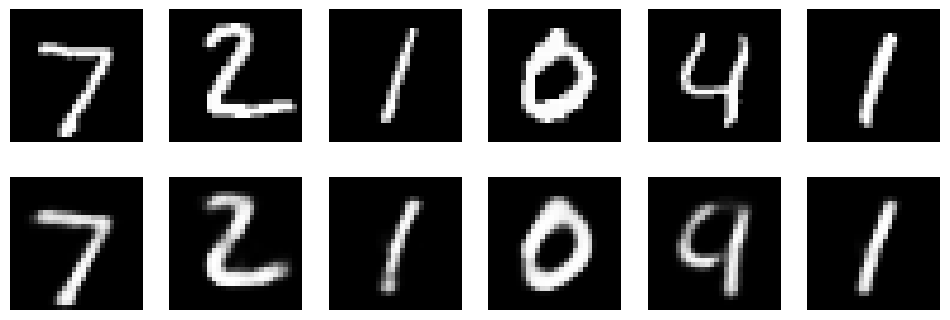

In [ ]:
import matplotlib.pyplot as plt

# Get some test images
model.eval()
with torch.no_grad():
    test_imgs, _ = next(iter(test_loader))
    test_imgs = test_imgs.view(test_imgs.size(0), -1).to(device)
    recon, _, _ = model(test_imgs)

# Original vs Reconstructed
n = 6
plt.figure(figsize=(12,4))
for i in range(n):
    # original
    plt.subplot(2,n,i+1)
    plt.imshow(test_imgs[i].cpu().view(28,28), cmap='gray')
    plt.axis('off')
    # reconstruction
    plt.subplot(2,n,i+1+n)
    plt.imshow(recon[i].cpu().view(28,28), cmap='gray')
    plt.axis('off')
plt.show()
